In [1]:
# Imports 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from keras import backend as K
import matplotlib.pyplot as plt 

In [2]:
# Import data
data = pd.read_csv("../../../data/mturk_experiment_2.csv",encoding='unicode_escape')
labels = data["Formality"]
samples = data["Sentence"]

# Testing with 90% training data
train_samples, test_samples, train_labels,test_labels = train_test_split(samples, labels, test_size=0.2,random_state=5)

train_samples = np.array(train_samples)
test_samples = np.array(test_samples)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [3]:
# Model setup

# Attention layer
class peel_the_layer(tf.keras.layers.Layer): 

    def __init__(self):    
        ##Nothing special to be done here
        super(peel_the_layer, self).__init__()

    def build(self, input_shape):
        ##Define the shape of the weights and bias in this layer
        ##This is a 1 unit layer. 
        units=1
        ##last index of the input_shape is the number of dimensions of the prev
        ##RNN layer. last but 1 index is the num of timesteps
        self.w=self.add_weight(name="att_weights", shape=(input_shape[-1], units), initializer="normal") #name property is useful for avoiding RuntimeError: Unable to create link.
        self.b=self.add_weight(name="att_bias", shape=(input_shape[-2], units), initializer="zeros")
        super(peel_the_layer,self).build(input_shape)

    def call(self, x):
        ##x is the input tensor..each word that needs to be attended to
        ##Below is the main processing done during training
        ##K is the Keras Backend import
        e = K.tanh(K.dot(x,self.w)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a

        ##return the ouputs. 'a' is the set of attention weights
        ##the second variable is the 'attention adjusted o/p state' or context
        return a, K.sum(output, axis=1)

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3'
tfhub_handle_preprocess =   'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
reshaped = tf.reshape(net,[-1, 768, 1])
lstm = tf.keras.layers.LSTM(512,return_sequences=True)(reshaped)
a, context = peel_the_layer()(lstm)

dense = tf.keras.layers.Dense(1)(context)
model = tf.keras.Model(text_input, dense)
model.summary()

loss = 'mse'
metrics = [tf.keras.metrics.MeanSquaredError(),tf.keras.losses.MeanAbsoluteError(),tf.keras.losses.MeanAbsolutePercentageError()]
optimiser = tf.optimizers.Adam(learning_rate= 5e-5)

model.compile(optimizer=optimiser, loss=loss, metrics=metrics)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  108310273   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [4]:
# Results setup

results = pd.DataFrame()

In [5]:
def train_test(model, epochs, batch_size, results):
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(x=train_samples,y=train_labels,batch_size=batch_size,epochs=epochs,verbose=2,callbacks=[callback])

    scores = model.evaluate(x=test_samples,y=test_labels)
    model_label = "Epochs - " + str(epochs) + " Batch Size - " + str(batch_size)

    results[model_label] = scores[1:]

    mse = history.history['mean_squared_error']
    mae = history.history['mean_absolute_error']
    mpe = history.history['mean_absolute_percentage_error']

    plt.plot(mse)
    #plt.plot(mae)
    #plt.plot(mpe)
    plt.title("Model: " + model_label)
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    #plt.legend(['MSE'], loc='upper right')

    #ymax = max([mse,mae])
    #ymax = max(ymax) + 1
    #plt.ylim(top=ymax)
    plt.ylim(bottom=0)
    plt.savefig(model_label + ".jpeg",dpi=100,bbox_inches='tight')

    return results

176/176 - 3002s - loss: 3.7057 - mean_squared_error: 3.7057 - mean_absolute_error: 1.3171 - mean_absolute_percentage_error: 34.5654
44/44 [==============================] - 222s 5s/step - loss: 0.5172 - mean_squared_error: 0.5172 - mean_absolute_error: 0.5799 - mean_absolute_percentage_error: 16.4654
88/88 - 3743s - loss: 0.4461 - mean_squared_error: 0.4461 - mean_absolute_error: 0.5310 - mean_absolute_percentage_error: 14.7997
44/44 [==============================] - 224s 5s/step - loss: 0.4860 - mean_squared_error: 0.4860 - mean_absolute_error: 0.5595 - mean_absolute_percentage_error: 16.5231


,0,1,2
Epochs - 1 Batch Size - 32,0.51719,0.579882,16.465361
Epochs - 1 Batch Size - 64,0.48598,0.559536,16.523079


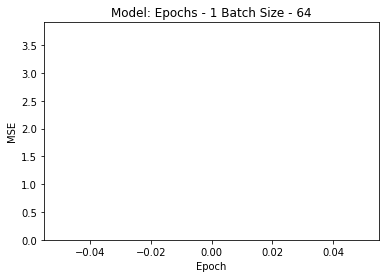

In [6]:
results = train_test(model,1,32,results)
results = train_test(model,1,64,results)
results.T

Epoch 1/2
176/176 - 3021s - loss: 0.3696 - mean_squared_error: 0.3696 - mean_absolute_error: 0.4818 - mean_absolute_percentage_error: 13.3224
Epoch 2/2
176/176 - 2974s - loss: 0.2140 - mean_squared_error: 0.2140 - mean_absolute_error: 0.3642 - mean_absolute_percentage_error: 9.9468
44/44 [==============================] - 223s 5s/step - loss: 0.5593 - mean_squared_error: 0.5593 - mean_absolute_error: 0.5938 - mean_absolute_percentage_error: 17.3299
Epoch 1/2
88/88 - 3897s - loss: 0.1147 - mean_squared_error: 0.1147 - mean_absolute_error: 0.2627 - mean_absolute_percentage_error: 7.1397
Epoch 2/2
88/88 - 4034s - loss: 0.0676 - mean_squared_error: 0.0676 - mean_absolute_error: 0.1996 - mean_absolute_percentage_error: 5.4415
44/44 [==============================] - 224s 5s/step - loss: 0.4905 - mean_squared_error: 0.4905 - mean_absolute_error: 0.5616 - mean_absolute_percentage_error: 16.0450


,0,1,2
Epochs - 1 Batch Size - 32,0.517190,0.579882,16.465361
Epochs - 1 Batch Size - 64,0.485980,0.559536,16.523079
Epochs - 2 Batch Size - 32,0.559299,0.593793,17.329901
Epochs - 2 Batch Size - 64,0.490477,0.561553,16.044975


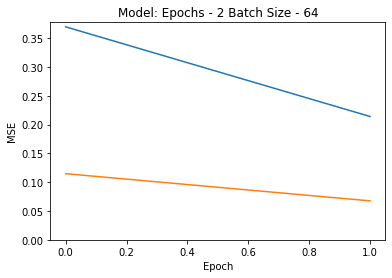

In [7]:
results = train_test(model,2,32,results)
results = train_test(model,2,64,results)
results.T

Epoch 1/3
176/176 - 3018s - loss: 0.0553 - mean_squared_error: 0.0553 - mean_absolute_error: 0.1819 - mean_absolute_percentage_error: 4.9845
Epoch 2/3
176/176 - 2983s - loss: 0.0680 - mean_squared_error: 0.0680 - mean_absolute_error: 0.2058 - mean_absolute_percentage_error: 5.6235
Epoch 3/3
176/176 - 2947s - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1863 - mean_absolute_percentage_error: 5.1012
44/44 [==============================] - 221s 5s/step - loss: 0.5157 - mean_squared_error: 0.5157 - mean_absolute_error: 0.5777 - mean_absolute_percentage_error: 15.8101
Epoch 1/3
88/88 - 4045s - loss: 0.0346 - mean_squared_error: 0.0346 - mean_absolute_error: 0.1452 - mean_absolute_percentage_error: 3.9866
Epoch 2/3
88/88 - 4353s - loss: 0.0218 - mean_squared_error: 0.0218 - mean_absolute_error: 0.1157 - mean_absolute_percentage_error: 3.1785
Epoch 3/3
88/88 - 4162s - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.1002 - mean_absolute_percentage_erro

,0,1,2
Epochs - 1 Batch Size - 32,0.517190,0.579882,16.465361
Epochs - 1 Batch Size - 64,0.485980,0.559536,16.523079
Epochs - 2 Batch Size - 32,0.559299,0.593793,17.329901
Epochs - 2 Batch Size - 64,0.490477,0.561553,16.044975
Epochs - 3 Batch Size - 32,0.515664,0.577692,15.810142
Epochs - 3 Batch Size - 64,0.476732,0.554432,15.614956


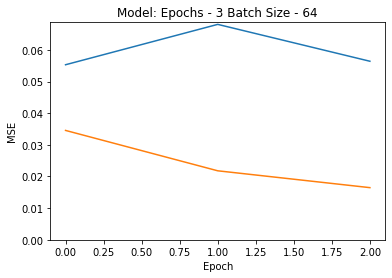

In [8]:
results = train_test(model,3,32,results)
results = train_test(model,3,64,results)
results.T

Epoch 1/4
176/176 - 3073s - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1103 - mean_absolute_percentage_error: 3.0523
Epoch 2/4
176/176 - 3520s - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.1434 - mean_absolute_percentage_error: 3.9402
Epoch 3/4
176/176 - 3673s - loss: 0.0403 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1582 - mean_absolute_percentage_error: 4.3590
Epoch 4/4
176/176 - 3698s - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.1468 - mean_absolute_percentage_error: 4.0171
44/44 [==============================] - 247s 6s/step - loss: 0.4849 - mean_squared_error: 0.4849 - mean_absolute_error: 0.5612 - mean_absolute_percentage_error: 15.4270
Epoch 1/4
88/88 - 4458s - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1275 - mean_absolute_percentage_error: 3.4979
Epoch 2/4
88/88 - 4757s - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0969 - mean_absolute_percentage_er

,0,1,2
Epochs - 1 Batch Size - 32,0.517190,0.579882,16.465361
Epochs - 1 Batch Size - 64,0.485980,0.559536,16.523079
Epochs - 2 Batch Size - 32,0.559299,0.593793,17.329901
Epochs - 2 Batch Size - 64,0.490477,0.561553,16.044975
Epochs - 3 Batch Size - 32,0.515664,0.577692,15.810142
Epochs - 3 Batch Size - 64,0.476732,0.554432,15.614956
Epochs - 4 Batch Size - 32,0.484865,0.561191,15.426952
Epochs - 4 Batch Size - 64,0.469810,0.550754,15.704459


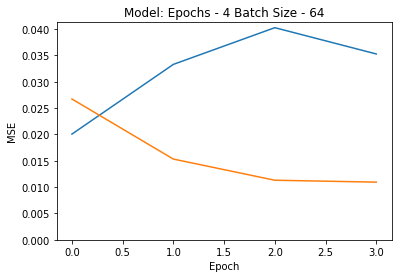

In [9]:
results = train_test(model,4,32,results)
results = train_test(model,4,64,results)
results.T

Epoch 1/8
176/176 - 3179s - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0962 - mean_absolute_percentage_error: 2.6545
Epoch 2/8
176/176 - 3196s - loss: 0.0223 - mean_squared_error: 0.0223 - mean_absolute_error: 0.1180 - mean_absolute_percentage_error: 3.2108
Epoch 3/8
176/176 - 3199s - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1186 - mean_absolute_percentage_error: 3.2204
Epoch 4/8
176/176 - 3182s - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1197 - mean_absolute_percentage_error: 3.2877
44/44 [==============================] - 242s 5s/step - loss: 0.4787 - mean_squared_error: 0.4787 - mean_absolute_error: 0.5558 - mean_absolute_percentage_error: 15.4756
Epoch 1/8
88/88 - 4478s - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.1057 - mean_absolute_percentage_error: 2.8726
Epoch 2/8
88/88 - 4575s - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0828 - mean_absolute_percentage_er

,0,1,2
Epochs - 1 Batch Size - 32,0.517190,0.579882,16.465361
Epochs - 1 Batch Size - 64,0.485980,0.559536,16.523079
Epochs - 2 Batch Size - 32,0.559299,0.593793,17.329901
Epochs - 2 Batch Size - 64,0.490477,0.561553,16.044975
Epochs - 3 Batch Size - 32,0.515664,0.577692,15.810142
Epochs - 3 Batch Size - 64,0.476732,0.554432,15.614956
Epochs - 4 Batch Size - 32,0.484865,0.561191,15.426952
Epochs - 4 Batch Size - 64,0.469810,0.550754,15.704459
Epochs - 8 Batch Size - 32,0.478685,0.555827,15.475608
Epochs - 8 Batch Size - 64,0.464775,0.547797,15.566788


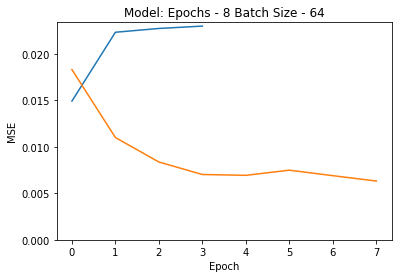

In [10]:
results = train_test(model,8,32,results)
results = train_test(model,8,64,results)
results.T

In [12]:
results = train_test(model,30,32,results)
results = train_test(model,30,64,results)
results.T

Epoch 1/30
176/176 - 3445s - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1215 - mean_absolute_percentage_error: 3.3024
Epoch 2/30
176/176 - 3304s - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1297 - mean_absolute_percentage_error: 3.5181
Epoch 3/30
176/176 - 4424s - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1221 - mean_absolute_percentage_error: 3.3195
Epoch 4/30


KeyboardInterrupt: 

In [ ]:
results = results.T
results.to_csv("bert_tests_20_test_80_train.csv")
results